In [1]:
import csv
import pandas
import numpy as np
import matplotlib.pyplot as plt
import json

c:\Users\Sebyb\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\Sebyb\anaconda3\lib\site-packages\numpy\.libs\libopenblas.4SP5SUA7CBGXUEOC35YP2ASOICYYEQZZ.gfortran-win_amd64.dll
c:\Users\Sebyb\anaconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [3]:
# Read the data from the CSV file
filename = 'model_1_2_3_folds.csv'
data = pandas.read_csv(filename)


# Split hyperparameters into separate columns from dict, with keys as column names
data = data.join(data['Hyperparameters'].apply(eval).apply(pandas.Series))

# Convert to dataframe
data = pandas.DataFrame(data)

# Convert all column names to lower case and remove spaces with _
data.columns = data.columns.str.lower().str.replace(' ', '_')
print(data.columns)

# Apply eval to the train and val losses columns
data['train_losses'] = data['train_losses'].apply(eval)
data['val_losses'] = data['val_losses'].apply(eval)

data_backup = data.copy()

print(data.head(1))

Index(['fold', 'hyperparameters', 'train_losses', 'val_losses', 'val_accuracy',
       'val_precision', 'val_recall', 'val_f1', 'time_taken',
       'early_stop_epoch', 'epochs', 'lr', 'bn', 'batch_size', 'dropout_rate',
       'hidden_layers', 'activations', 'input_size', 'weight_decay',
       'optimiser', 'early_stopping'],
      dtype='object')
   fold                                    hyperparameters  \
0     1  {"epochs": 50, "lr": 0.0001, "bn": 0, "batch_s...   

                                        train_losses  \
0  [2.128602706856402, 1.8732740702722648, 1.8015...   

                                          val_losses  val_accuracy  \
0  [1.9400573034521054, 1.8449675105924417, 1.795...        0.4236   

   val_precision  val_recall    val_f1  time_taken  early_stop_epoch  ...  \
0       0.418033    0.425256  0.417364   76.294093               NaN  ...   

       lr  bn  batch_size  dropout_rate  hidden_layers            activations  \
0  0.0001   0           4     [0, 

In [6]:
# Ablation configuration
# Import json file from filepath
ablation_config_file = 'configs/config_ablation_1_2_3.json'

# Read in the json file as a dictionary
with open(ablation_config_file) as json_file:
    ablation_config = json.load(json_file)['ablation_dict']

In [7]:
# Function to create average train and val losses across the folds for a given dataframe
def create_avg_train_val_losses(temp_data):
    # Collate the first 10 train losses into a list
    train_losses = np.ndarray(shape=(10, 50))
    for i in range(10):
        # Fill the ith row with the train losses of the ith fold filling with zeros if the length is less than 50
        train_losses[i, :len(temp_data.iloc[i]['train_losses'])] = temp_data.iloc[i]['train_losses']

    # Collate the first 10 val losses into a list
    val_losses = np.ndarray(shape=(10, 50))
    for i in range(10):
        val_losses[i, :len(temp_data.iloc[i]['val_losses'])] = temp_data.iloc[i]['val_losses']

    # Create an average of the first 10 train losses between the folds, dividing each element by the number of non-zero elements
    train_losses_avg = np.sum(train_losses, axis=0) / np.sum(train_losses != 0, axis=0)
    val_losses_avg = np.sum(val_losses, axis=0) / np.sum(val_losses != 0, axis=0)
    return train_losses_avg, val_losses_avg

In [8]:
print(ablation_config)

{'weight_decay': [0.005, 0.01, 0.02, 0.05]}


In [9]:
##### Baseline data #####
# set first 10 rows as data_baseline
data_baseline = data.iloc[:10].copy()
train_losses_baseline, val_losses_baseline = create_avg_train_val_losses(data_baseline)

In [10]:
#### Split data into different datasets based on the ablation configuration ####
# Iterate over dictionary and sort into another dict of dataframes based on the key
data_dict = {}
for key, values in ablation_config.items():
    # Split into datasets with key as the key for data_dict, and only including rows where the value is in the values
    data_dict[key] = data[data[key].isin(values)]

In [11]:
# Create a new dictionary to store the mean train and val losses for each dataset in data_dict at a specific key
data_copy = data.copy()
mean_losses_dict = {}
for key, data in data_dict.items():
    temp_losses_dict = {}
    for value in ablation_config[key]:
        # Create a new key in the mean_losses_dict for the key and value pair
        temp_data = data_copy[data_copy[key].astype(str) == str(value)].copy()
        temp_losses_dict[str(key) + '_' + str(value)] = create_avg_train_val_losses(temp_data)
    mean_losses_dict[key] = temp_losses_dict

# Something causes data to be modified, so we need to reset it
data = data_backup.copy()
print(len(data))

50


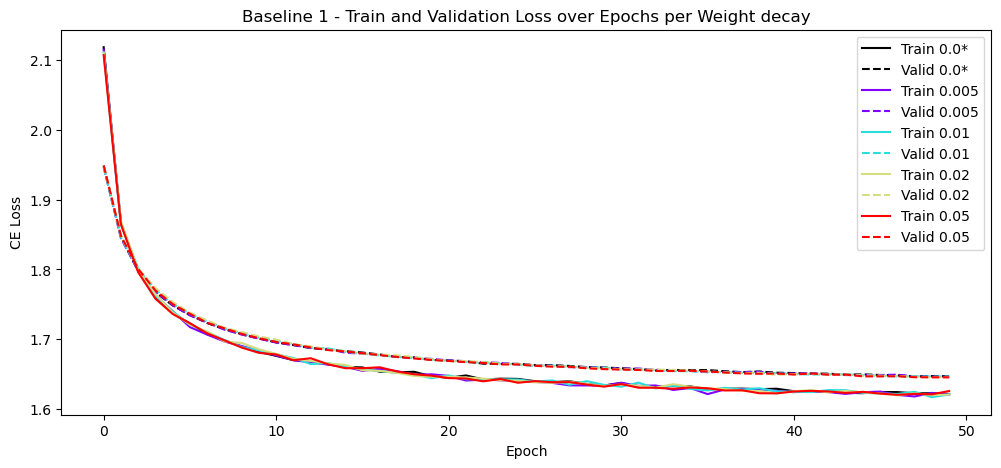

In [12]:
for key, values in mean_losses_dict.items():
    # Graph the average train and val losses for each dataset in the mean_losses_dict
    n = len(values)
    # color = iter(plt.rainbow(np.linspace(0, 1, n*2)))
    cmap = plt.get_cmap('rainbow', n)
    plt.figure(figsize=(12, 5))
    plt.title(f'Baseline 1 - Train and Validation Loss over Epochs per {key.replace("_", " ").capitalize()}')
    plt.xlabel('Epoch')
    plt.ylabel('CE Loss')
    # Plot the baseline data
    baseline_label = data_baseline[key][0]
    if key == 'activations':
        baseline_label = baseline_label[1]
    plt.plot(train_losses_baseline, label=f'Train {baseline_label}*', color='black')
    plt.plot(val_losses_baseline, label=f'Valid {baseline_label}*', color='black', linestyle='dashed')
    i = 0
    for key_hp, losses in values.items():
        if key in ['batch_size', 'weight_decay', 'dropout_rate', 'optimiser', 'bn']:
            label = key_hp.split('_')[-1]
        elif key == 'activations':
            label = key_hp.split('_')[-1].split(',')[1].replace("'", "").replace(' ', '')
        else:
            label = key_hp
            
        
        plt.plot(losses[0], label=f'Train {label}', color=cmap(i))
        plt.plot(losses[1], label=f'Valid {label}', color=cmap(i), linestyle='dashed')
        i += 1
    
    plt.legend()
    plt.show()
    

In [84]:
# # Function that takes in a dict of different hyperparameter values and graphs boxplots of the metrics (val_accuracy, val_precision, val_recall, val_f1) per hyperparameter values
# def graph_metrics(data_dict, metric):
#     # Group plots for each metric (val_accuracy, val_precision, val_recall, val_f1) into a single figure with 4 subplots
#     fig, axs = plt.subplots(1, 4, figsize=(20, 5))
#     fig.suptitle(f'{metric} for different hyperparameters')
#     print(data_dict.keys())
#     # Align labels of y-axis for all subplots, only show the label for the first subplot
#     # Plot the boxplots for each metric in each subplot
#     axs[0].set_title('Validation Accuracy')
#     axs[0].set_ylabel('Accuracy')
#     axs[0].boxplot([data_dict[key]['val_accuracy'] for key in data_dict.keys()], labels=[key for key in data_dict.keys()])
#     axs[1].set_title('Validation Precision')
#     axs[1].set_ylabel('Precision')
#     axs[1].boxplot([data_dict[key]['val_precision'] for key in data_dict.keys()], labels=[key for key in data_dict.keys()])
#     axs[2].set_title('Validation Recall')
#     axs[2].set_ylabel('Recall')
#     axs[2].boxplot([data_dict[key]['val_recall'] for key in data_dict.keys()], labels=[key for key in data_dict.keys()])
#     axs[3].set_title('Validation F1')
#     axs[3].set_ylabel('F1')
#     axs[3].boxplot([data_dict[key]['val_f1'] for key in data_dict.keys()], labels=[key for key in data_dict.keys()])
#     plt.show()

In [148]:
# def graph_metrics(datasets, values, hp):
#     # Group plots for each metric (val_accuracy, val_precision, val_recall, val_f1) into a single figure with 4 subplots
#     fig, axs = plt.subplots(1, 4, figsize=(18, 5), sharey=True)
#     fig.suptitle(f'Validation metrics for different {hp}')
#     # Align labels of y-axis for all subplots, only show the label for the first subplot
#     # print first key in datasets to check if it is a string and if it is longer than 5 characters
    
#     if hp in ['Dropout Rate']:
#         # Set the x-axis labels to be vertical if the string is longer than 5 characters
#         axs[0].tick_params(axis='x', rotation=45)
#         axs[1].tick_params(axis='x', rotation=45)
#         axs[2].tick_params(axis='x', rotation=45)
#         axs[3].tick_params(axis='x', rotation=45)
#     # Plot the boxplots for each metric in each subplot
#     axs[0].set_title('Validation Accuracy')
#     # axs[0].set_ylabel('Accuracy')
#     axs[0].boxplot([datasets[value]['val_accuracy'] for value in values], labels=[value for value in values])
#     axs[1].set_title('Validation Precision')
#     # axs[1].set_ylabel('Precision')
#     axs[1].boxplot([datasets[value]['val_precision'] for value in values], labels=[value for value in values])
#     axs[2].set_title('Validation Recall')
#     # axs[2].set_ylabel('Recall')
#     axs[2].boxplot([datasets[value]['val_recall'] for value in values], labels=[value for value in values])
#     axs[3].set_title('Validation F1')
#     # axs[3].set_ylabel('F1')
#     axs[3].boxplot([datasets[value]['val_f1'] for value in values], labels=[value for value in values])
#     plt.show()

In [13]:
def graph_metrics(datasets, values, hp):
    # Group plots for each metric (val_accuracy, val_precision, val_recall, val_f1) into a single figure with 4 subplots
    fig, axs = plt.subplots(1, 4, figsize=(16, 4), sharey=True)
    fig.suptitle(f'Baseline 1 - Validation metrics for different {hp}')
    # Align labels of y-axis for all subplots, only show the label for the first subplot
    # print first key in datasets to check if it is a string and if it is longer than 5 characters
    
    if hp in ['Dropout Rate']:
        for ax in axs:
            ax.tick_params(axis='x', rotation=45)
            
    metrics = ['val_accuracy', 'val_precision', 'val_recall', 'val_f1']
    titles = ['Validation Accuracy', 'Validation Precision', 'Validation Recall', 'Validation F1']
    
    for ax, metric, title in zip(axs, metrics, titles):
        ax.set_title(title)
        ax.boxplot([datasets[value][metric] for value in values], labels=[value for value in values])
        
        # Enable y-axis labels and ticks for all subplots
        ax.tick_params(axis='y', which='both', left=True, right=False, labelleft=True)
        
    plt.show()

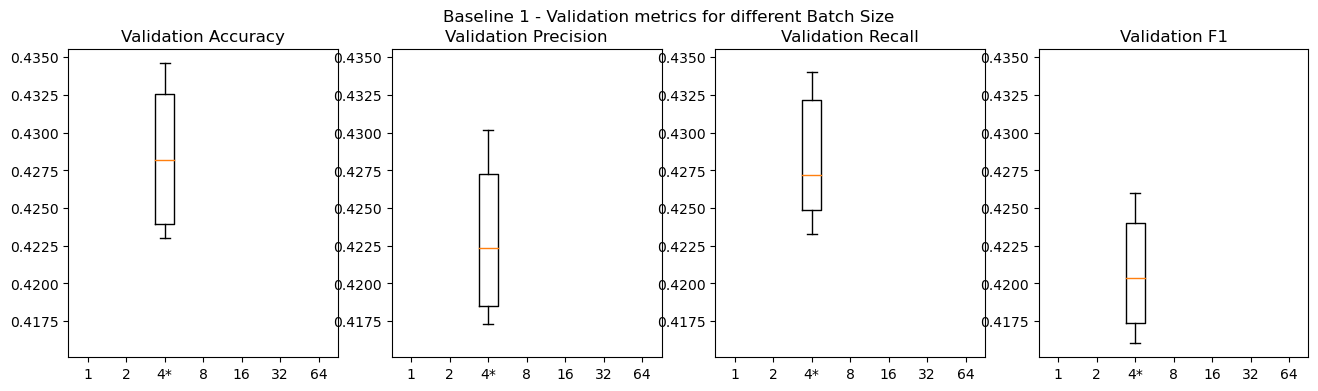

In [14]:
# Not working
data_batch_size_1 = data[data['batch_size'] == 1]
data_batch_size_2 = data[data['batch_size'] == 2]
data_batch_size_4 = data_baseline
data_batch_size_8 = data[data['batch_size'] == 8]
data_batch_size_16 = data[data['batch_size'] == 16]
data_batch_size_32 = data[data['batch_size'] == 32]
data_batch_size_64 = data[data['batch_size'] == 64]

batch_datasets = {'1': data_batch_size_1, '2': data_batch_size_2, '4*': data_batch_size_4, '8': data_batch_size_8, '16': data_batch_size_16, '32': data_batch_size_32, '64': data_batch_size_64}
graph_metrics(batch_datasets, ['1', '2', '4*', '8', '16', '32', '64'], 'Batch Size')

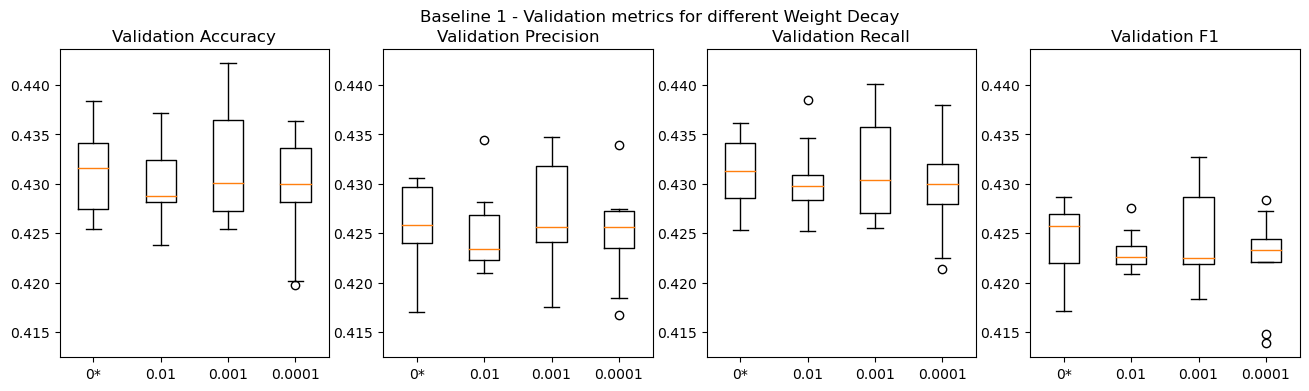

In [195]:
# Graph metrics for weight decay
# "weight_decay": [0.005, 0.01, 0.02, 0.05]
data_weight_decay_0 = data_baseline
data_weight_decay_0_005 = data[data['weight_decay'] == 0.005]
data_weight_decay_0_01 = data[data['weight_decay'] == 0.01]
data_weight_decay_0_02 = data[data['weight_decay'] == 0.02]
data_weight_decay_0_05 = data[data['weight_decay'] == 0.05]
weight_decay_datasets = {'0*': data_weight_decay_0, '0.005': data_weight_decay_0_005, '0.01': data_weight_decay_0_01, '0.02': data_weight_decay_0_02, '0.05': data_weight_decay_0_05}
graph_metrics(weight_decay_datasets, weight_decay_datasets.keys(), 'Weight Decay')


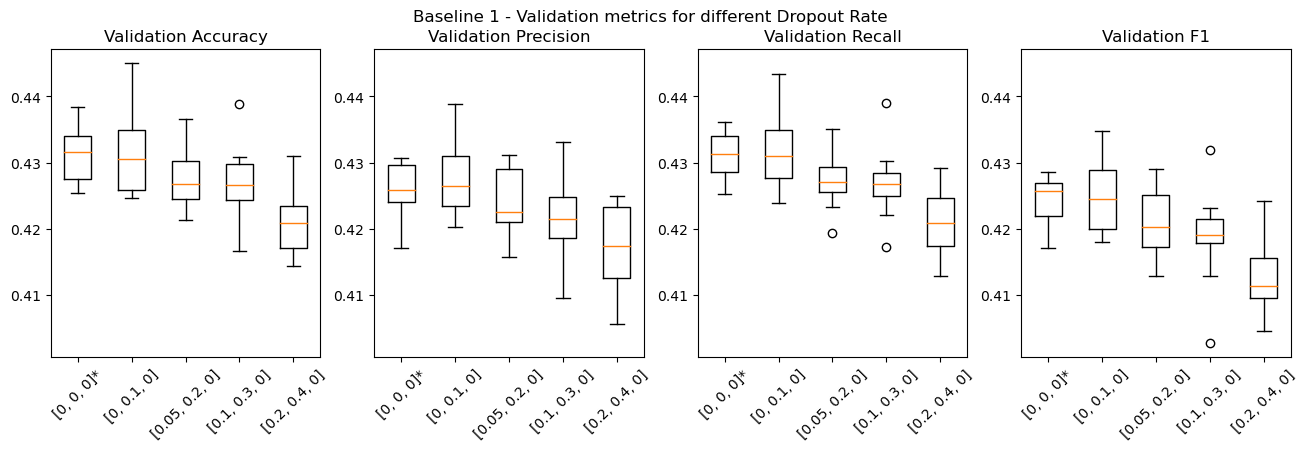

In [196]:
# Graph metrics for dropout rate
dropout_rate_datasets = {
    '[0, 0, 0]*': data_baseline,
    '[0, 0.1, 0]': data[data['dropout_rate'].astype(str) == '[0, 0.1, 0]'],
    '[0.05, 0.2, 0]': data[data['dropout_rate'].astype(str) == '[0.05, 0.2, 0]'],
    '[0.1, 0.3, 0]': data[data['dropout_rate'].astype(str) == '[0.1, 0.3, 0]'],
    '[0.2, 0.4, 0]': data[data['dropout_rate'].astype(str) == '[0.2, 0.4, 0]']
}
graph_metrics(dropout_rate_datasets, dropout_rate_datasets.keys(), 'Dropout Rate')

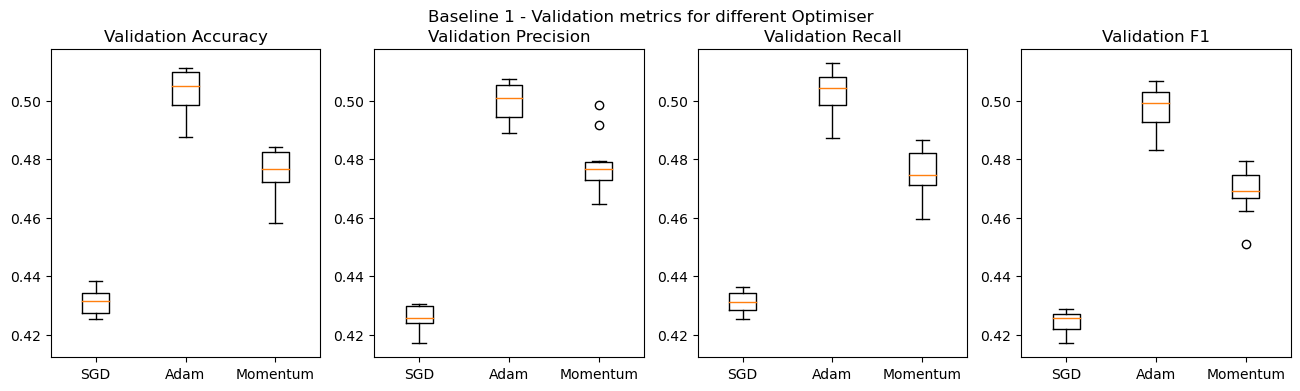

In [197]:
# Graph metrics for optimiser
data_adam = data[data['optimiser'] == 'Adam']
data_momentum = data[data['optimiser'] == 'Momentum']

optimiser_datasets = {'SGD': data_baseline, 'Adam': data_adam, 'Momentum': data_momentum}
graph_metrics(optimiser_datasets, optimiser_datasets.keys(), 'Optimiser')

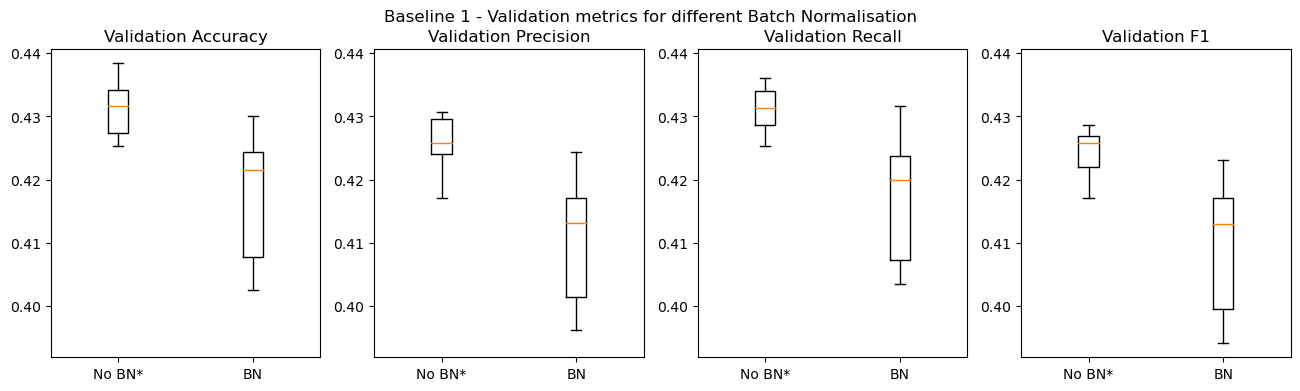

In [198]:
# Graph metrics for batch normalisation
data_no_bn = data_baseline
data_bn = data[data['bn'] == 1]

bn_datasets = {'No BN*': data_no_bn, 'BN': data_bn}
graph_metrics(bn_datasets, bn_datasets.keys(), 'Batch Normalisation')

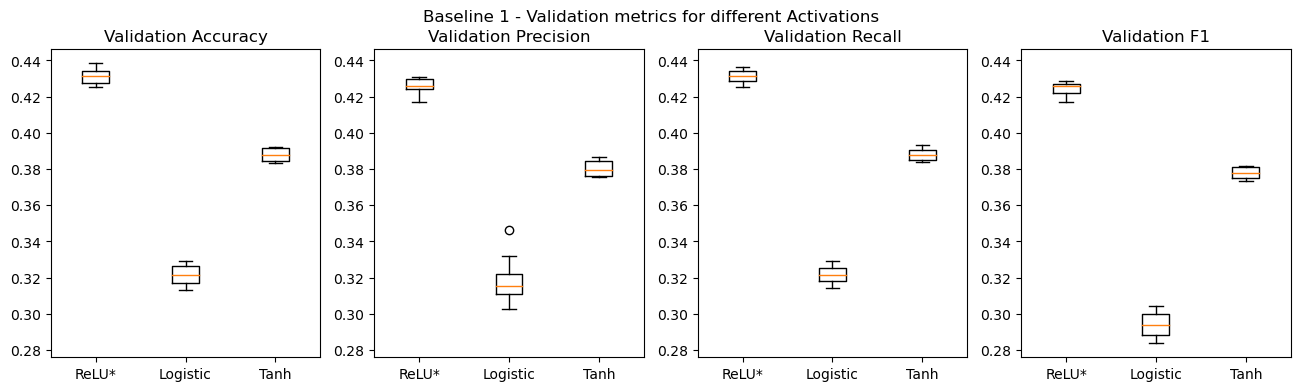

In [199]:
# Graph metrics for activations
data_relu_activation = data_baseline
data_logistic_softmax = data[data['activations'].astype(str) == "['None', 'logistic', 'softmax']"]
data_tanh_softmax = data[data['activations'].astype(str) == "['None', 'tanh', 'softmax']"]

activation_datasets = {'ReLU*': data_relu_activation, 'Logistic': data_logistic_softmax, 'Tanh': data_tanh_softmax}
graph_metrics(activation_datasets, activation_datasets.keys(), 'Activations')

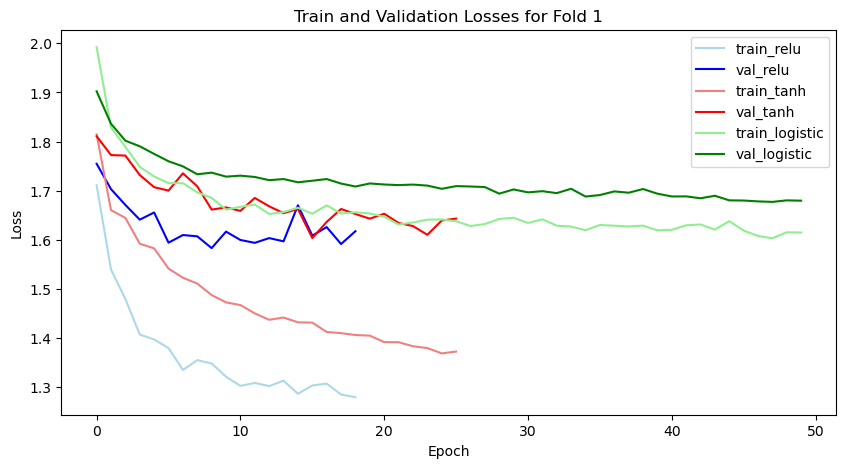

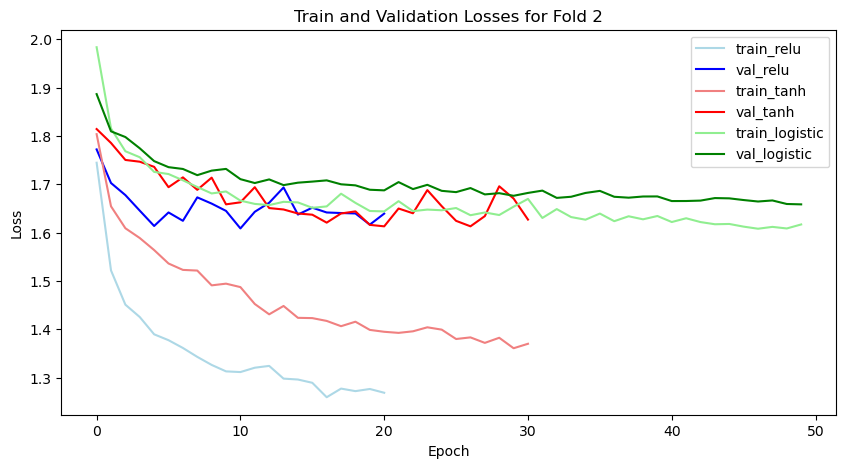

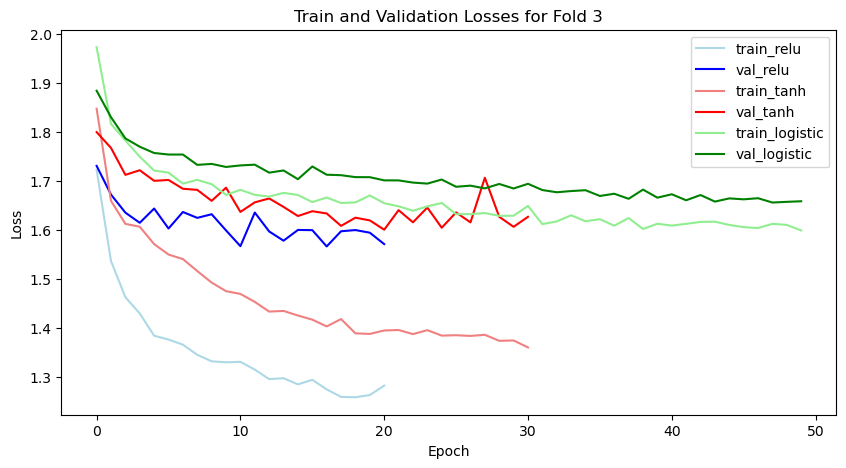

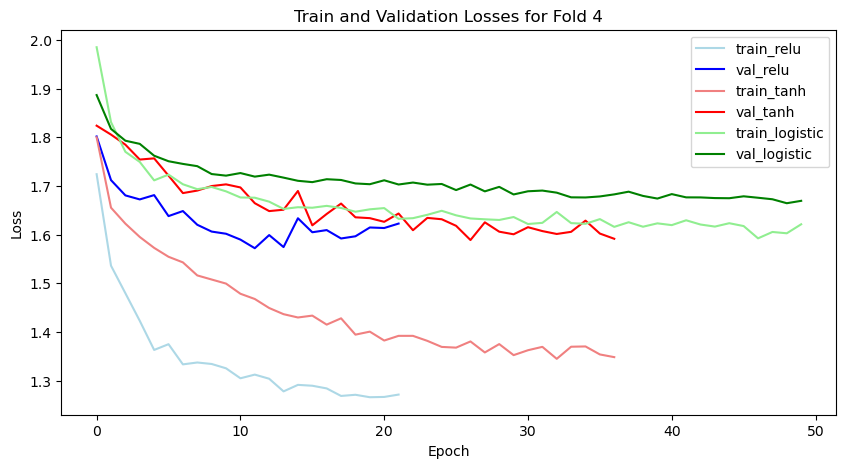

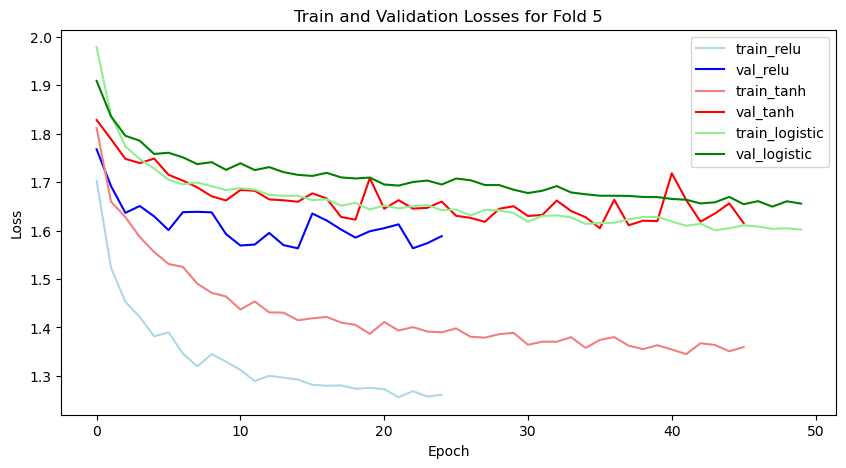

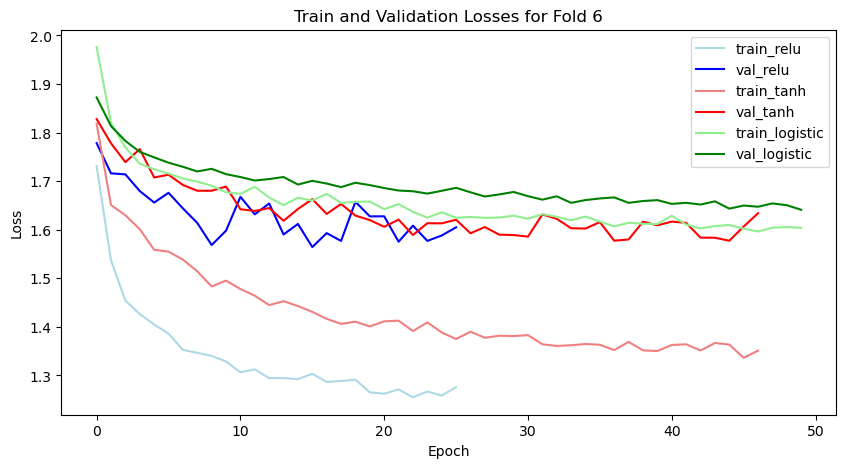

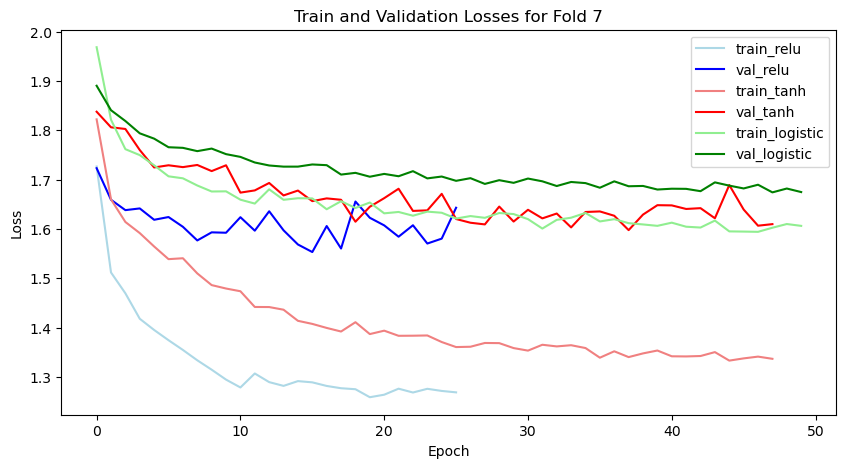

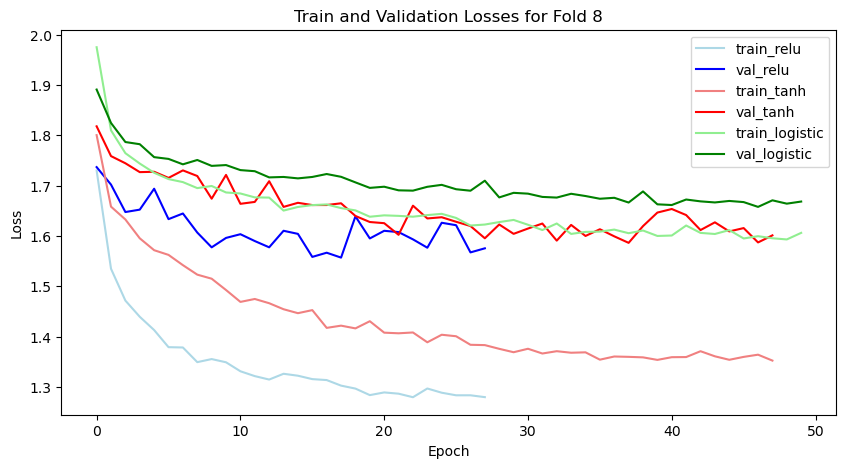

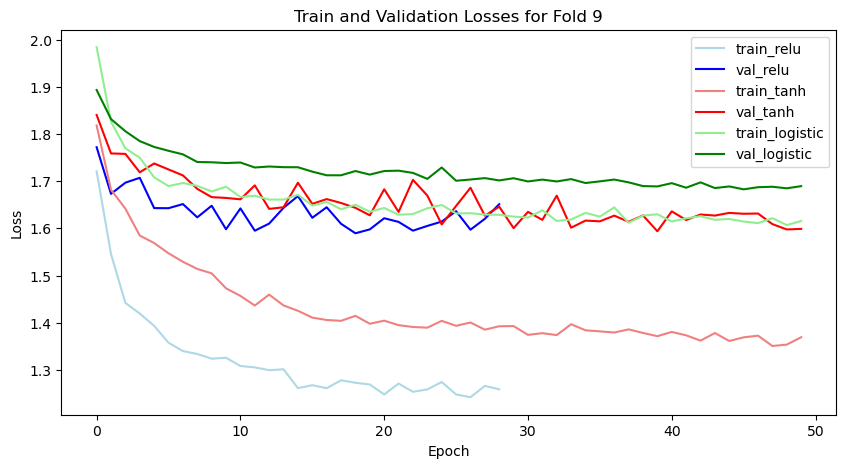

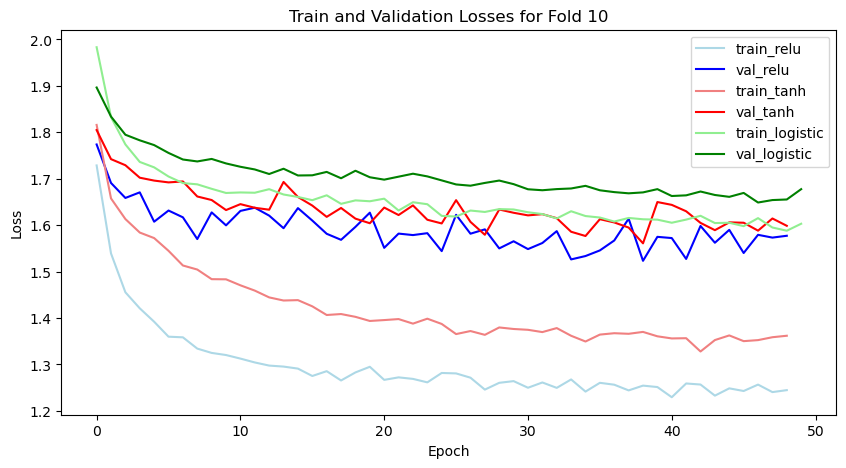

In [9]:
# Graph the average training and validation losses of the baseline and the activation functions tanh and logistic
# 2 hues of the same color for each of the train and val losses per activation function. eg. relu blue and light blue, tanh red and light red, logistic green and light green
for i in range(10):
    # Set plot size
    plt.figure(figsize=(10, 5))
    # Set plot title and axis labels
    plt.title('Train and Validation Losses for Fold ' + str(i+1))
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    # Plot the training and validation losses for the baseline, tanh and logistic activation functions
    plt.plot(data_baseline.iloc[i]['train_losses'], label='train_relu', color='lightblue')
    plt.plot(data_baseline.iloc[i]['val_losses'], label='val_relu', color='blue')
    plt.plot(data_activations_tanh.iloc[i]['train_losses'], label='train_tanh', color='lightcoral')
    plt.plot(data_activations_tanh.iloc[i]['val_losses'], label='val_tanh', color='red')
    plt.plot(data_activations_logistic.iloc[i]['train_losses'], label='train_logistic', color='lightgreen')
    plt.plot(data_activations_logistic.iloc[i]['val_losses'], label='val_logistic', color='green')
    plt.legend()
    plt.show()

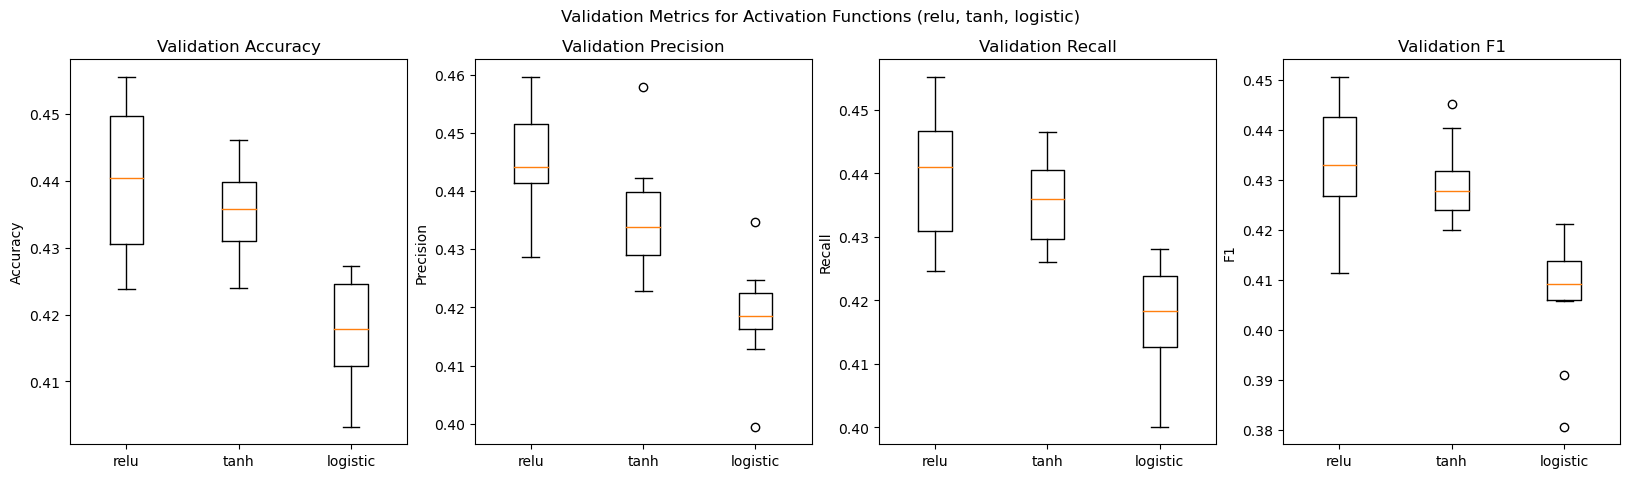

In [125]:
# Group plots for each metric (val_accuracy, val_precision, val_recall, val_f1) into a single figure with 4 subplots
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
fig.suptitle('Validation Metrics for Activation Functions (relu, tanh, logistic)')
# Align labels of y-axis for all subplots, only show the label for the first subplot
# Plot the boxplots for each metric in each subplot
axs[0].set_title('Validation Accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].boxplot([data_baseline['val_accuracy'], data_activations_tanh['val_accuracy'], data_activations_logistic['val_accuracy']], labels=['relu', 'tanh', 'logistic'])
axs[1].set_title('Validation Precision')
axs[1].set_ylabel('Precision')
axs[1].boxplot([data_baseline['val_precision'], data_activations_tanh['val_precision'], data_activations_logistic['val_precision'],], labels=['relu', 'tanh', 'logistic'])
axs[2].set_title('Validation Recall')
axs[2].set_ylabel('Recall')
axs[2].boxplot([data_baseline['val_recall'], data_activations_tanh['val_recall'], data_activations_logistic['val_recall'],], labels=['relu', 'tanh', 'logistic'])
axs[3].set_title('Validation F1')
axs[3].set_ylabel('F1')
axs[3].boxplot([data_baseline['val_f1'], data_activations_tanh['val_f1'], data_activations_logistic['val_f1'],], labels=['relu', 'tanh', 'logistic'])
plt.show()

In [25]:
# Analysis of batch sizes
# Find the folds with the batch size equals [1,2,4,8,16,32,64]
data_batch_size_1 = data[data['batch_size'] == 1]
data_batch_size_2 = data[data['batch_size'] == 2]
data_batch_size_8 = data[data['batch_size'] == 8]
data_batch_size_16 = data[data['batch_size'] == 16]
data_batch_size_32 = data[data['batch_size'] == 32]
data_batch_size_64 = data[data['batch_size'] == 64]

In [26]:
print(data_batch_size_8)

    fold                                    hyperparameters  \
30     1  {"epochs": 50, "lr": 0.001, "bn": 0, "batch_si...   
31     2  {"epochs": 50, "lr": 0.001, "bn": 0, "batch_si...   
32     3  {"epochs": 50, "lr": 0.001, "bn": 0, "batch_si...   
33     4  {"epochs": 50, "lr": 0.001, "bn": 0, "batch_si...   
34     5  {"epochs": 50, "lr": 0.001, "bn": 0, "batch_si...   
35     6  {"epochs": 50, "lr": 0.001, "bn": 0, "batch_si...   
36     7  {"epochs": 50, "lr": 0.001, "bn": 0, "batch_si...   
37     8  {"epochs": 50, "lr": 0.001, "bn": 0, "batch_si...   
38     9  {"epochs": 50, "lr": 0.001, "bn": 0, "batch_si...   
39    10  {"epochs": 50, "lr": 0.001, "bn": 0, "batch_si...   

                                         train_losses  \
30  [1.5900181781425005, 1.385500228330606, 1.3394...   
31  [1.5896148081461159, 1.3960656808316623, 1.341...   
32  [1.5994876506581586, 1.3910854348537274, 1.321...   
33  [1.6074215643388954, 1.4102545410184228, 1.348...   
34  [1.62565716333530

In [28]:
# Graph the average training and validation losses of the baseline and the batch sizes 1, 2, 8, 16, 32, 64
# 2 hues of the same color for each of the train and val losses per batch size. eg. 1 blue and light blue, 2 red and light red, 8 green and light green

# Create the average train and val losses for the batch size 1
train_losses_avg_batch_size_1, val_losses_avg_batch_size_1 = create_avg_train_val_losses(data_batch_size_1)

# Create the average train and val losses for the batch size 2
train_losses_avg_batch_size_2, val_losses_avg_batch_size_2 = create_avg_train_val_losses(data_batch_size_2)

# Create the average train and val losses for the batch size 8
train_losses_avg_batch_size_8, val_losses_avg_batch_size_8 = create_avg_train_val_losses(data_batch_size_8)

# Create the average train and val losses for the batch size 16
train_losses_avg_batch_size_16, val_losses_avg_batch_size_16 = create_avg_train_val_losses(data_batch_size_16)

# Create the average train and val losses for the batch size 32
train_losses_avg_batch_size_32, val_losses_avg_batch_size_32 = create_avg_train_val_losses(data_batch_size_32)

# Create the average train and val losses for the batch size 64
train_losses_avg_batch_size_64, val_losses_avg_batch_size_64 = create_avg_train_val_losses(data_batch_size_64)



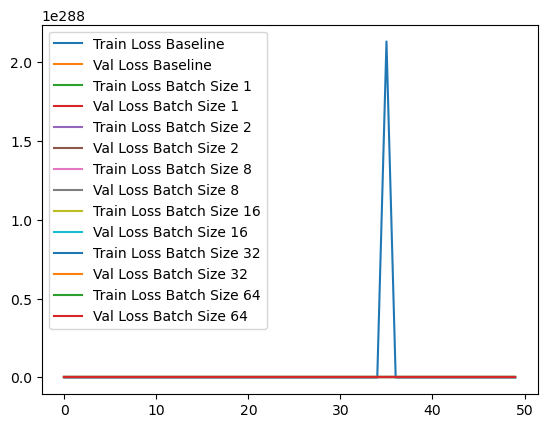

In [31]:
# Plot the average train and val losses over the epochs (iterations/index in the array)
plt.plot(train_losses_avg_baseline, label='Train Loss Baseline')
plt.plot(val_losses_avg_baseline, label='Val Loss Baseline')
plt.plot(train_losses_avg_batch_size_1, label='Train Loss Batch Size 1')
plt.plot(val_losses_avg_batch_size_1, label='Val Loss Batch Size 1')
plt.plot(train_losses_avg_batch_size_2, label='Train Loss Batch Size 2')
plt.plot(val_losses_avg_batch_size_2, label='Val Loss Batch Size 2')
plt.plot(train_losses_avg_batch_size_8, label='Train Loss Batch Size 8')
plt.plot(val_losses_avg_batch_size_8, label='Val Loss Batch Size 8')
plt.plot(train_losses_avg_batch_size_16, label='Train Loss Batch Size 16')
plt.plot(val_losses_avg_batch_size_16, label='Val Loss Batch Size 16')
plt.plot(train_losses_avg_batch_size_32, label='Train Loss Batch Size 32')
plt.plot(val_losses_avg_batch_size_32, label='Val Loss Batch Size 32')
plt.plot(train_losses_avg_batch_size_64, label='Train Loss Batch Size 64')
plt.plot(val_losses_avg_batch_size_64, label='Val Loss Batch Size 64')
plt.legend()


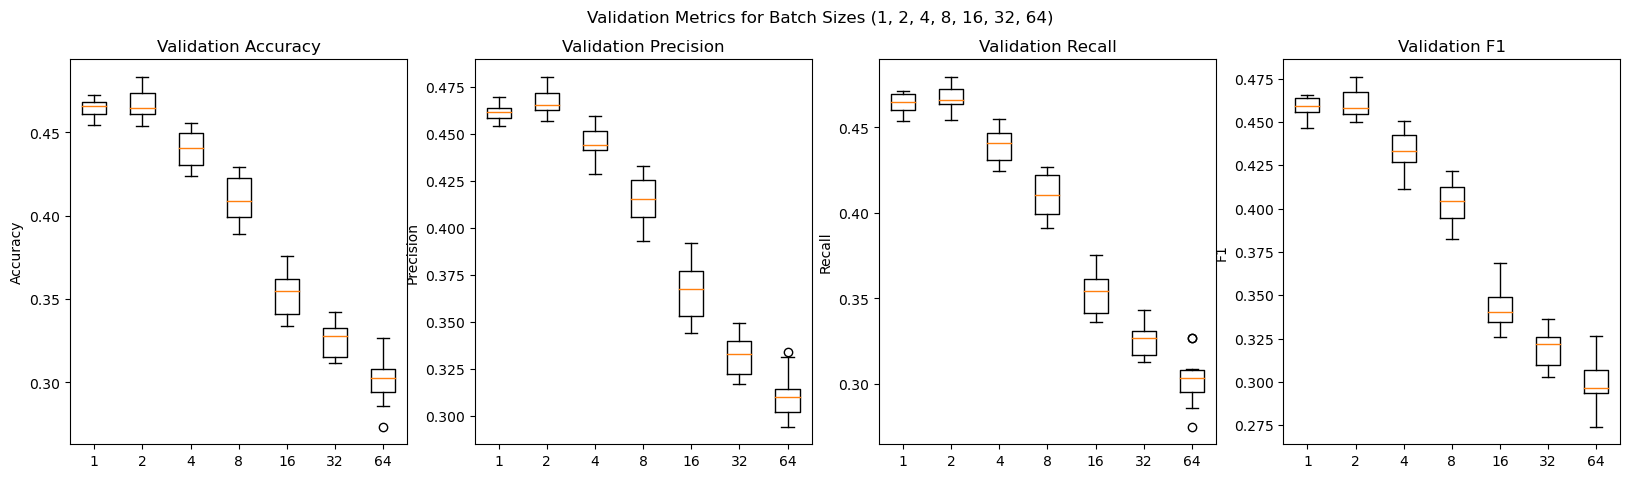

In [30]:
data_batch_size_1 = data[data['batch_size'] == 1]
data_batch_size_2 = data[data['batch_size'] == 2]
data_batch_size_8 = data[data['batch_size'] == 8]
data_batch_size_16 = data[data['batch_size'] == 16]
data_batch_size_32 = data[data['batch_size'] == 32]
data_batch_size_64 = data[data['batch_size'] == 64]

# Group plots for each metric (val_accuracy, val_precision, val_recall, val_f1) into a single figure with 4 subplots
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
fig.suptitle('Validation Metrics for Batch Sizes (1, 2, 4, 8, 16, 32, 64)')
# Align labels of y-axis for all subplots, only show the label for the first subplot
# Plot the boxplots for each metric in each subplot
axs[0].set_title('Validation Accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].boxplot([data_batch_size_1['val_accuracy'], data_batch_size_2['val_accuracy'], data_baseline['val_accuracy'], data_batch_size_8['val_accuracy'], data_batch_size_16['val_accuracy'], data_batch_size_32['val_accuracy'], data_batch_size_64['val_accuracy']], labels=['1', '2', '4', '8', '16', '32', '64'])
axs[1].set_title('Validation Precision')
axs[1].set_ylabel('Precision')
axs[1].boxplot([data_batch_size_1['val_precision'], data_batch_size_2['val_precision'], data_baseline['val_precision'], data_batch_size_8['val_precision'], data_batch_size_16['val_precision'], data_batch_size_32['val_precision'], data_batch_size_64['val_precision']], labels=['1', '2', '4', '8', '16', '32', '64'])
axs[2].set_title('Validation Recall')
axs[2].set_ylabel('Recall')
axs[2].boxplot([data_batch_size_1['val_recall'], data_batch_size_2['val_recall'], data_baseline['val_recall'], data_batch_size_8['val_recall'], data_batch_size_16['val_recall'], data_batch_size_32['val_recall'], data_batch_size_64['val_recall']], labels=['1', '2', '4', '8', '16', '32', '64'])
axs[3].set_title('Validation F1')
axs[3].set_ylabel('F1')
axs[3].boxplot([data_batch_size_1['val_f1'], data_batch_size_2['val_f1'], data_baseline['val_f1'], data_batch_size_8['val_f1'], data_batch_size_16['val_f1'], data_batch_size_32['val_f1'], data_batch_size_64['val_f1']], labels=['1', '2', '4', '8', '16', '32', '64'])
plt.show()


# A function that does the above, taking a range of values for a hyperparameter and plotting the metrics for each metric and each value
def plot_metrics(data, key, values):
    # Group plots for each metric (val_accuracy, val_precision, val_recall, val_f1) into a single figure with 4 subplots
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))
    fig.suptitle(f'Validation Metrics for {key} {values}')
    # Align labels of y-axis for all subplots, only show the label for the first subplot
    # Plot the boxplots for each metric in each subplot
    axs[0].set_title('Validation Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].boxplot([data[data[key] == value]['val_accuracy'] for value in values], labels=values)
    axs[1].set_title('Validation Precision')
    axs[1].set_ylabel('Precision')
    axs[1].boxplot([data[data[key] == value]['val_precision'] for value in values], labels=values)
    axs[2].set_title('Validation Recall')
    axs[2].set_ylabel('Recall')
    axs[2].boxplot([data[data[key] == value]['val_recall'] for value in values], labels=values)
    axs[3].set_title('Validation F1')
    axs[3].set_ylabel('F1')
    axs[3].boxplot([data[data[key] == value]['val_f1'] for value in values], labels=values)
    plt.show()